Testing

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# Avoiding warnings

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
dublin_station_location = pd.read_csv('dublin_station_location.csv')

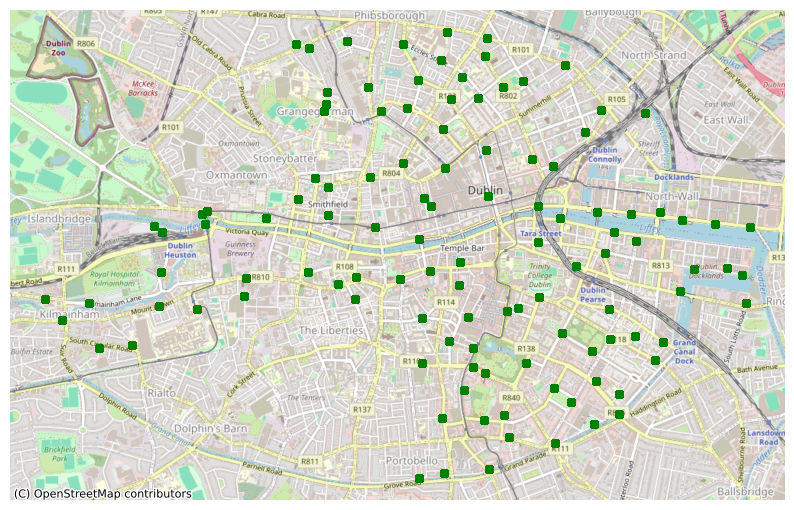

In [3]:
import plotly.express as px
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx


# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(dublin_station_location, geometry=gpd.points_from_xy(dublin_station_location['long'], dublin_station_location['lat']))

# Set coordinate reference system to WGS84 (EPSG:4326) and convert to Web Mercator (EPSG:3857)
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='green', markersize=30)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for a cleaner look
ax.set_axis_off()

plt.show()






#dublin_distribution = px.scatter_mapbox(dublinn_station_location, lat='lat', lon='long', color_discrete_sequence=["blue"], zoom=12, height=600)

#dublin_distribution.update_traces(marker=dict(size=30, color='green'), selector=dict(mode='markers'))
#dublin_distribution.update_layout(mapbox_style="open-street-map")
#dublin_distribution.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

#dublin_distribution.show() 

# Font: Adapted from https://medium.com/@gersongoulartjnr/manipulando-dados-geoespaciais-com-geopandas-607db23175b1

In [4]:
boston_station_location = pd.read_csv('boston_station_location.csv')

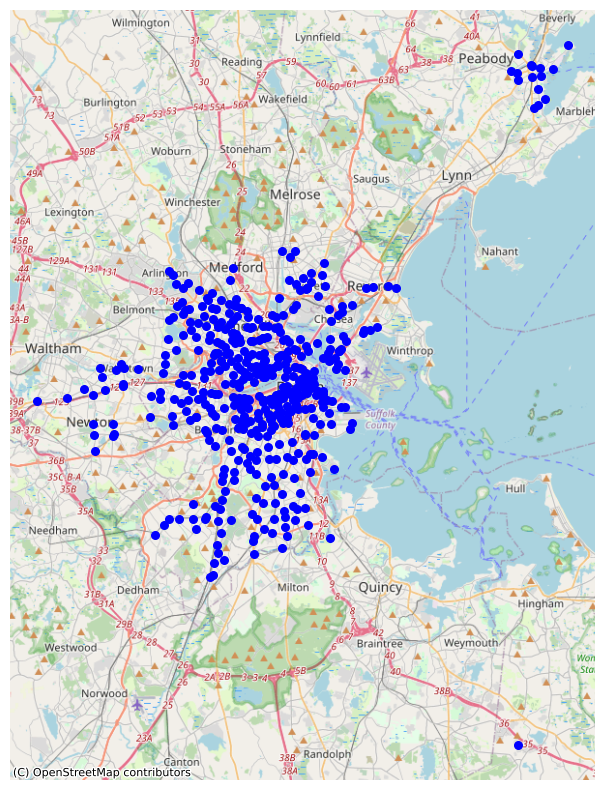

In [5]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(boston_station_location, geometry=gpd.points_from_xy(boston_station_location['long'], boston_station_location['lat']))

# Set coordinate reference system to WGS84 (EPSG:4326) and convert to Web Mercator (EPSG:3857)
gdf = gdf.set_crs(epsg=4326)
gdf = gdf.to_crs(epsg=3857)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, marker='o', color='blue', markersize=30)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis for a cleaner look
ax.set_axis_off()

plt.show()